# Payment Behaviour

In [1]:
# -------------------------------------------------------------------
# Setup cell — place this at the top of every analysis notebook
# -------------------------------------------------------------------
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm

df = pd.read_csv("../datasets/customer_shopping_data_v10.csv")
sns.set_theme(style="whitegrid")

color1 = '#FF9E9D'  # Coral Pink
color2 = '#FFC785'  # Peach
color3 = '#FFF59D'  # Light Lemon
color4 = '#A0E6A6'  # Mint Green
color5 = '#87C8FF'  # Sky Blue
color6 = '#C4A2FF'  # Lavender

1. payment_method ↔ invoice_date <br>
What are the trends in payment method shares over time?

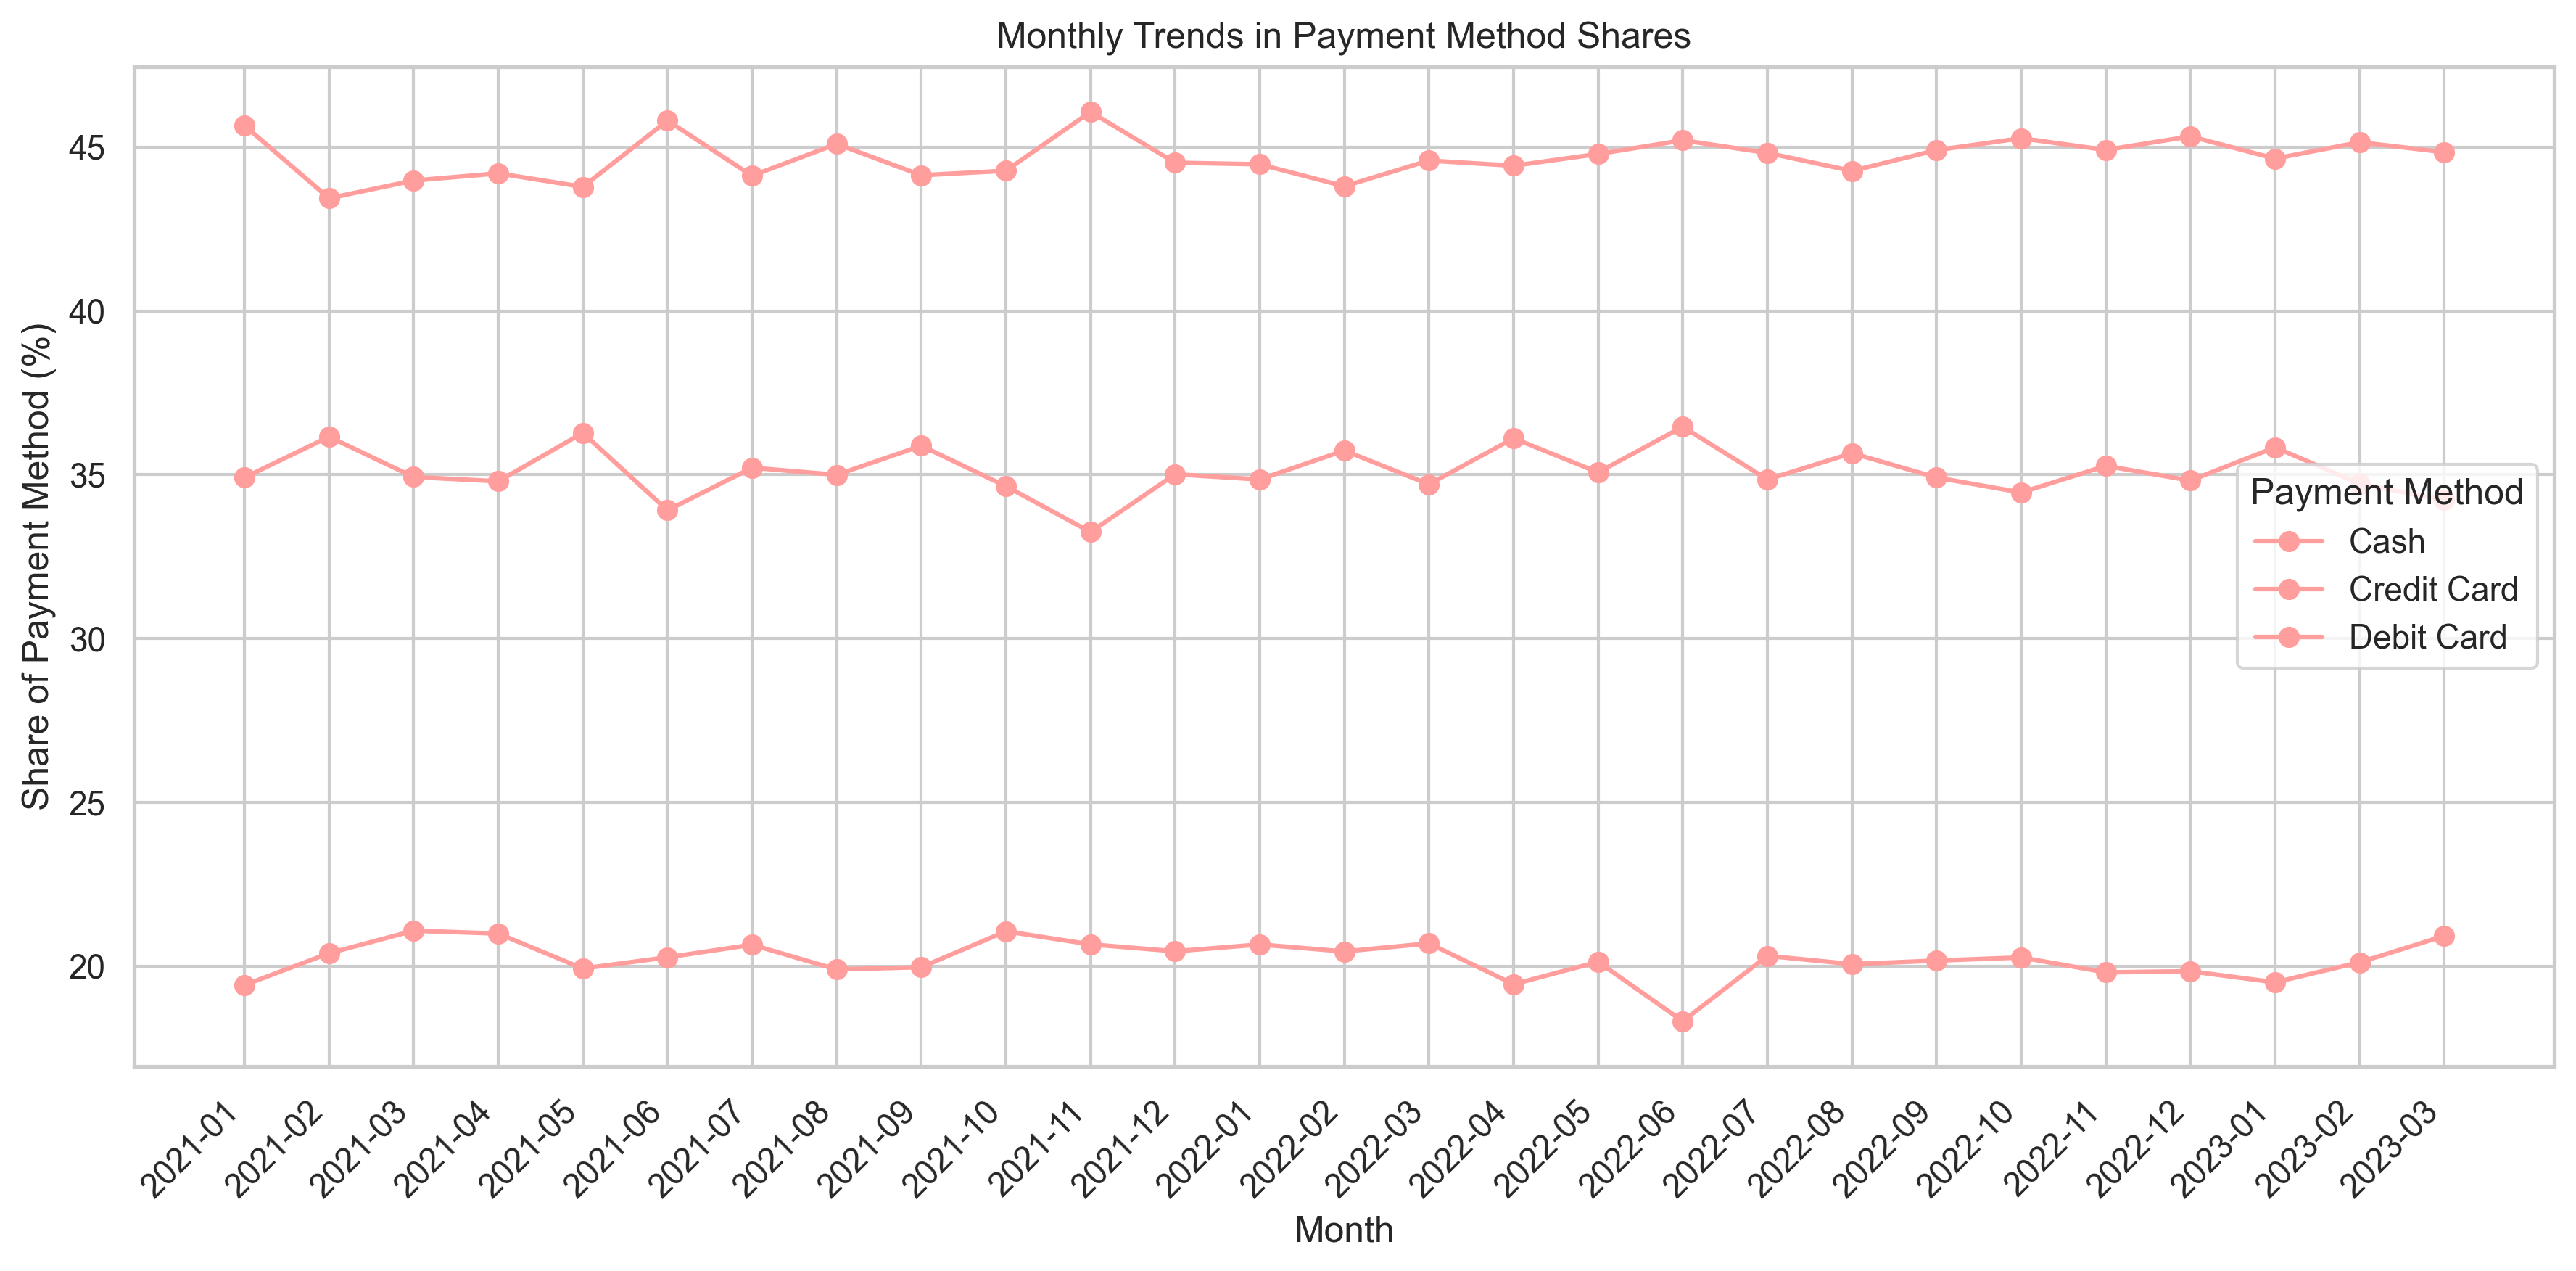


Payment Method: Cash
                            OLS Regression Results                            
Dep. Variable:                   Cash   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.268
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.145
Time:                        16:02:39   Log-Likelihood:                -24.597
No. Observations:                  27   AIC:                             53.19
Df Residuals:                      25   BIC:                             55.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3629      0.2

In [2]:
#Warning: These patterns—especially the absence of any temporal trends despite the impact of Covid-19 and economic deterioration—strongly suggest that this dataset may be synthetic or artificially balanced.

# 1. Convert invoice_date to datetime
df["invoice_date"] = pd.to_datetime(df["invoice_date"])
df["year_month"] = df["invoice_date"].dt.to_period("M").astype(str)

# 2. Count transactions by payment method and month
payment_trends = (
    df.groupby(["year_month", "payment_method"])
      .size()
      .reset_index(name="transaction_count")
)

# 3. Calculate total transactions per month
monthly_totals = (
    payment_trends.groupby("year_month")["transaction_count"]
    .sum()
    .reset_index(name="total_transactions")
)

# 4. Merge totals back into main DataFrame
payment_trends = payment_trends.merge(
    monthly_totals,
    on="year_month"
)

# 5. Compute share percentage
payment_trends["share_percent"] = (
    payment_trends["transaction_count"] / payment_trends["total_transactions"] * 100
)

# 6. Pivot data for plotting and regression
pivot_df = payment_trends.pivot(
    index="year_month",
    columns="payment_method",
    values="share_percent"
).fillna(0)

# 7. Encode time as sequential integers
pivot_df = pivot_df.sort_index()
pivot_df["time_index"] = range(1, len(pivot_df)+1)

# 8. Plot line chart of payment method shares over time
plt.figure(figsize=(12,6), dpi=300)
for col in pivot_df.columns.drop("time_index"):
    plt.plot(
        pivot_df.index,
        pivot_df[col],
        marker='o',
        label=col,
        color=color1,
    )
plt.xlabel("Month")
plt.ylabel("Share of Payment Method (%)")
plt.title("Monthly Trends in Payment Method Shares")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Payment Method")
plt.tight_layout()
plt.savefig("dataset_payment_behavior_figures/payment_time_series.png", dpi=300)
plt.show()

# 9. Fit linear regression for each payment method
for method in pivot_df.columns.drop("time_index"):
    y = pivot_df[method]
    X = pivot_df["time_index"]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    coef = model.params["time_index"]
    p_value = model.pvalues["time_index"]

    print(f"\nPayment Method: {method}")
    print(model.summary())

    if p_value < 0.05:
        trend = "increasing" if coef > 0 else "decreasing"
        print(f"✅ Significant {trend} trend over time. p-value: {p_value}")
    else:
        print(f"❌ No significant trend over time. p-value: {p_value}")


In [3]:
# 1. Payment Method only summary statistics
summary_payment = (
    df.groupby(["payment_method"])["total_price"]
      .describe()
      .round(2)
      .reset_index()
)

print("\nSummary statistics by Payment Method (regardless of gender):\n")
display(summary_payment)


Summary statistics by Payment Method (regardless of gender):



,payment_method,count,mean,std,min,25%,50%,75%,max
0,Cash,44447.0,2538.58,4235.04,5.23,130.75,600.17,2700.72,26250.0
1,Credit Card,34931.0,2521.46,4215.18,5.23,130.75,600.17,2700.72,26250.0
2,Debit Card,20079.0,2519.87,4207.44,5.23,136.35,600.17,2700.72,26250.0


2. payment_method ↔ gender <br>
How does payment method preference vary by gender?

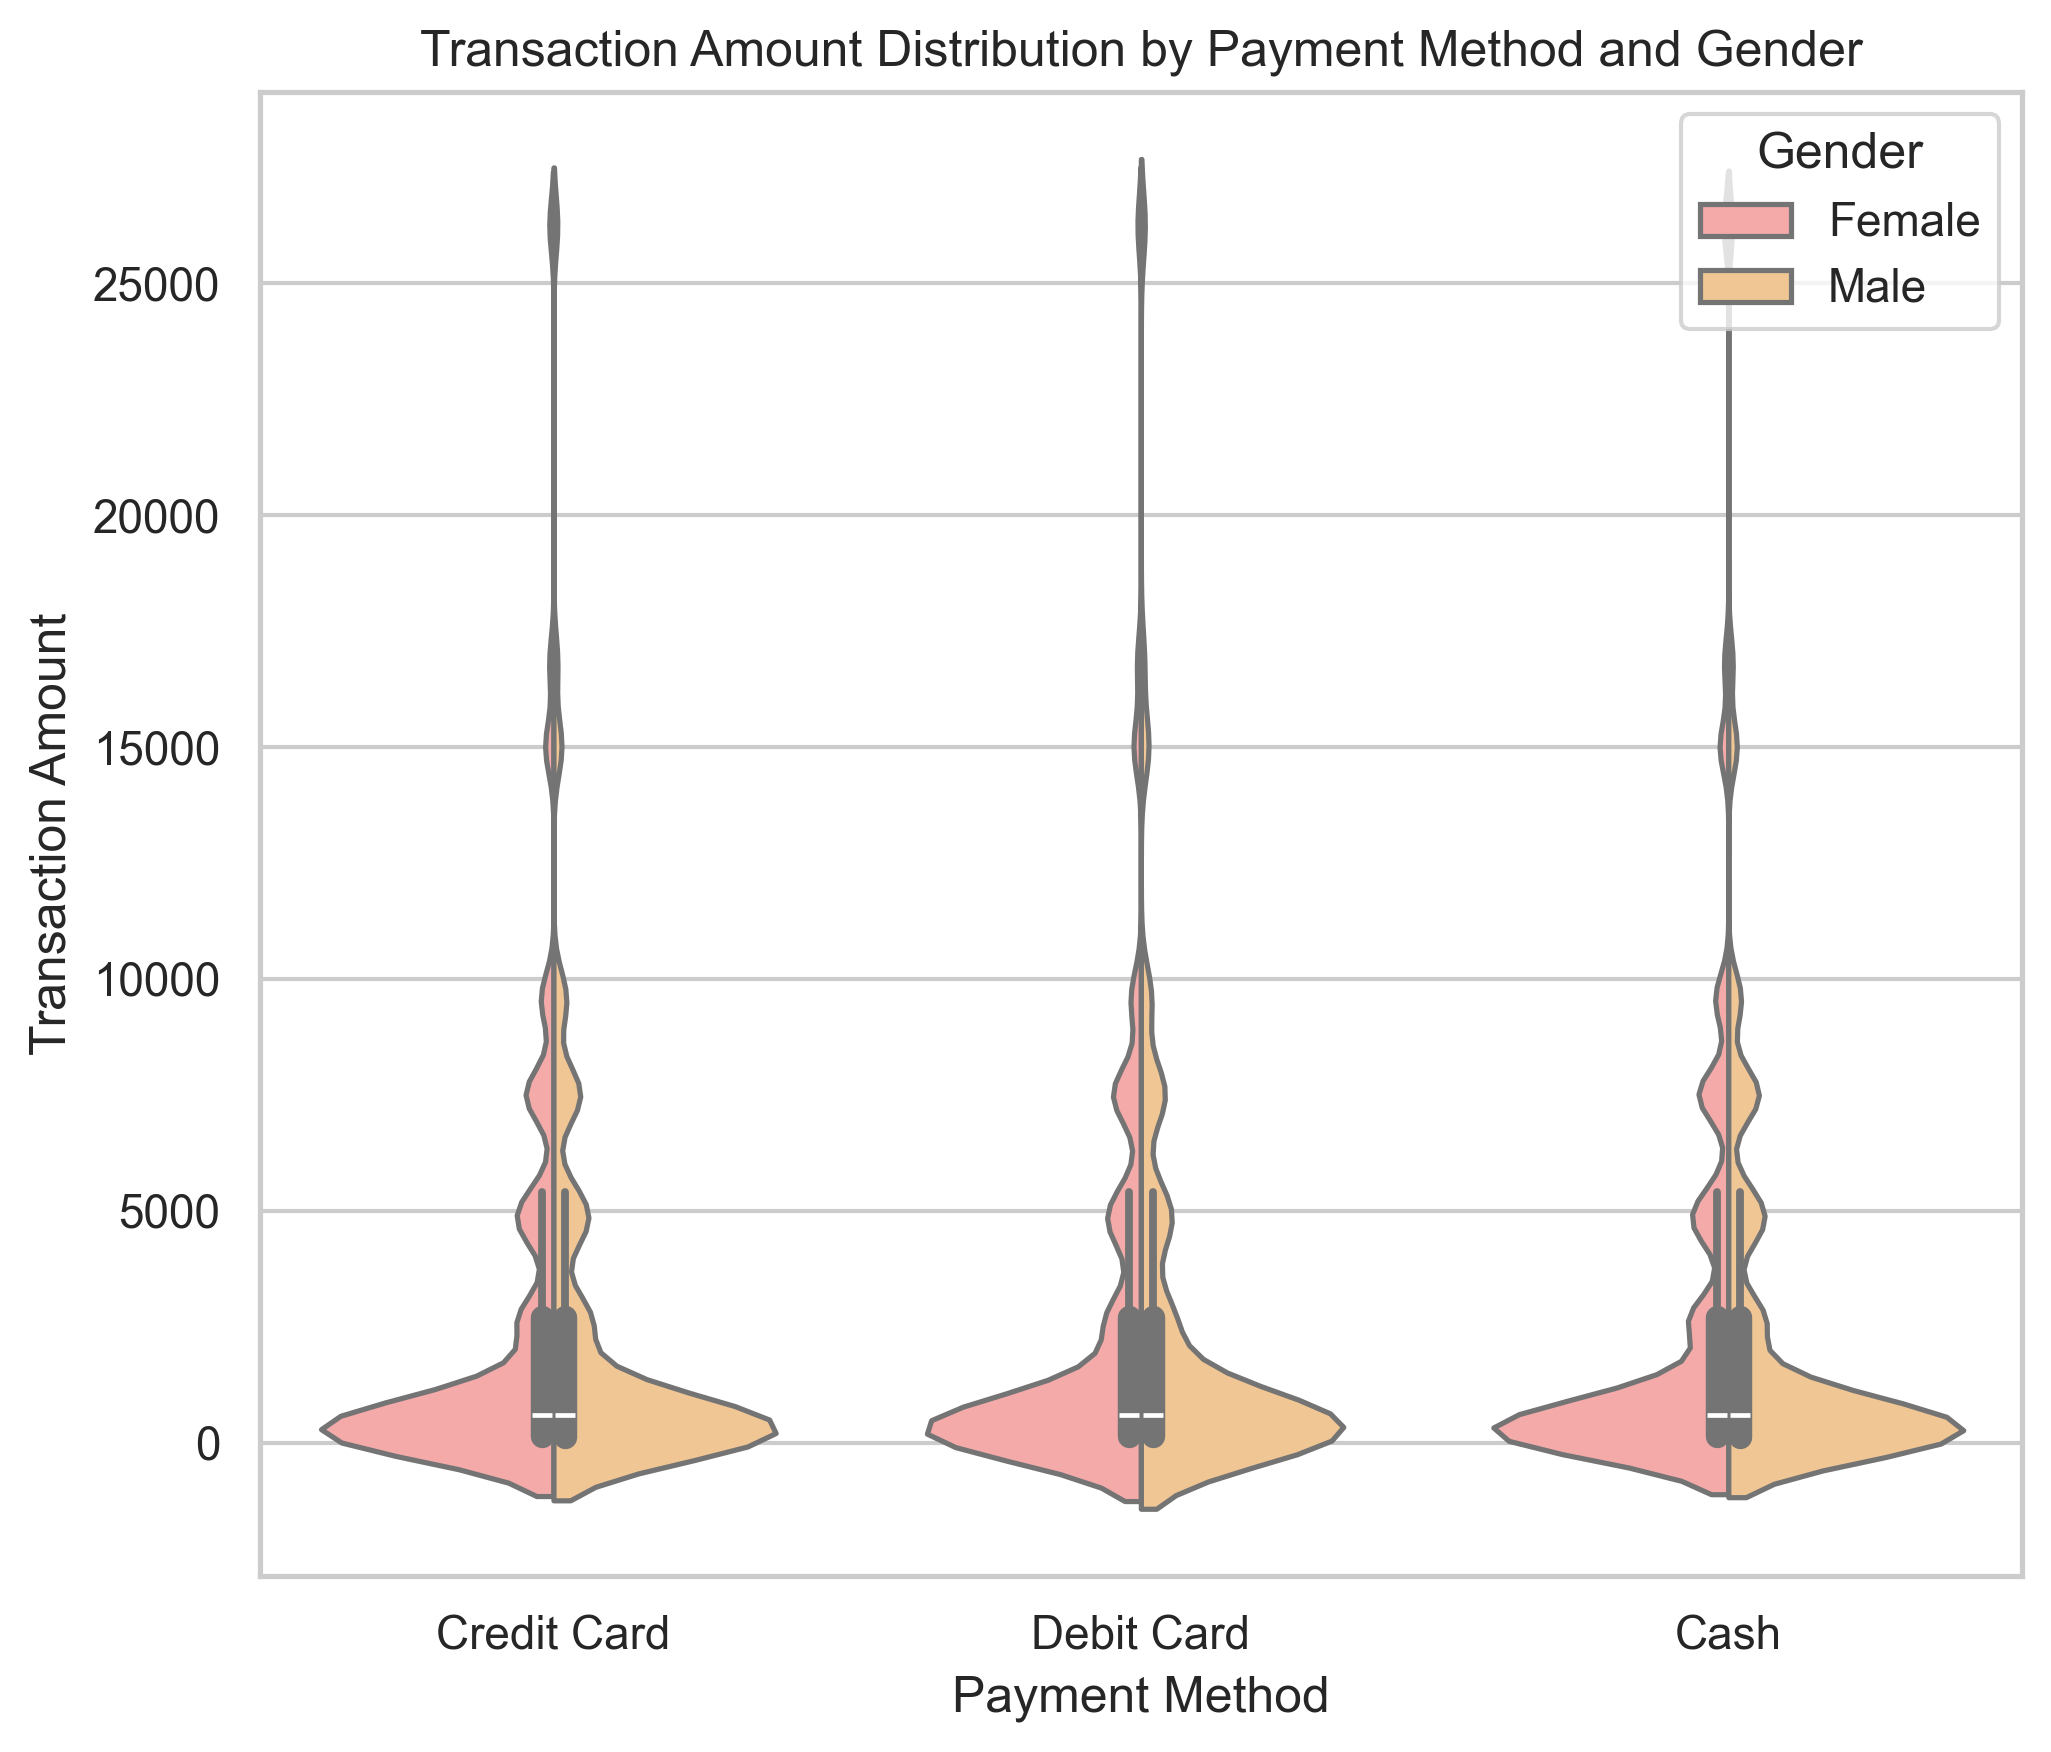


=== Observed Counts (Payment Method × Gender) ===
gender          Female   Male
payment_method               
Cash             26509  17938
Credit Card      21011  13920
Debit Card       11962   8117

=== Expected Counts Under Null Hypothesis (Independence) ===
gender            Female      Male
payment_method                    
Cash            26582.31  17864.69
Credit Card     20891.10  14039.90
Debit Card      12008.60   8070.40

Chi-Squared Test Results:
  χ² statistic = 2.6650
  Degrees of freedom = 2
  p-value = 0.2638

❌ p = 0.2638 ≥ 0.05 → Fail to reject H₀.
Conclusion: No statistically significant association between gender and payment method preference at the 95% confidence level.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --------------------------------------------------------
# Gender ↔ Payment Method analysis
# --------------------------------------------------------

# contingency table (rows = payment, cols = gender)
ct = pd.crosstab(df["payment_method"], df["gender"])

# total shoppers per gender
gender_tot = df["gender"].value_counts()

# % share = count / gender_total
pct = ct.divide(gender_tot, axis=1) * 100

methods   = ct.index.tolist()
genders   = ct.columns.tolist()
x         = np.arange(len(methods))
width     = 0.35

# fixed colors
gender_colors = {"Female": color1, "Male": color2}


# --- Violin plot (distribution of transaction amounts) ---
plt.figure(figsize=(7,6), dpi=300)
sns.violinplot(
    data=df,
    x="payment_method",
    y="total_price",
    hue="gender",
    split=True,
    palette=gender_colors
)
plt.title("Transaction Amount Distribution by Payment Method and Gender")
plt.xlabel("Payment Method")
plt.ylabel("Transaction Amount")
plt.legend(title="Gender")
plt.tight_layout()
plt.savefig("dataset_payment_behavior_figures/payment_gender_violin.png", dpi=300)
plt.show()

# --- Chi-squared test ---
chi2, p, dof, exp = stats.chi2_contingency(ct)

expected_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns)

# --- Clean print statements ---
print("\n=== Observed Counts (Payment Method × Gender) ===")
print(ct)

print("\n=== Expected Counts Under Null Hypothesis (Independence) ===")
print(expected_df.round(2))

print(f"\nChi-Squared Test Results:")
print(f"  χ² statistic = {chi2:.4f}")
print(f"  Degrees of freedom = {dof}")
print(f"  p-value = {p:.4f}")

alpha = 0.05
if p < alpha:
    print(f"\n✅ p = {p:.4f} < {alpha} → Reject H₀.")
    print("Conclusion: Payment method preference differs significantly by gender at the 95% confidence level.")
else:
    print(f"\n❌ p = {p:.4f} ≥ {alpha} → Fail to reject H₀.")
    print("Conclusion: No statistically significant association between gender and payment method preference at the 95% confidence level.")


In [5]:
# 1. Gender × Payment Method summary statistics
summary_gender_payment = (
    df.groupby(["gender", "payment_method"])["total_price"]
      .describe()
      .round(2)
      .reset_index()
)

print("\nSummary statistics by Gender × Payment Method:\n")
display(summary_gender_payment)


Summary statistics by Gender × Payment Method:



,gender,payment_method,count,mean,std,min,25%,50%,75%,max
0,Female,Cash,26509.0,2549.08,4272.09,5.23,136.35,600.17,2700.72,26250.0
1,Female,Credit Card,21011.0,2516.58,4224.42,5.23,136.35,600.17,2700.72,26250.0
2,Female,Debit Card,11962.0,2487.68,4128.01,5.23,136.35,600.17,2700.72,26250.0
3,Male,Cash,17938.0,2523.06,4179.76,5.23,130.75,600.17,2700.72,26250.0
4,Male,Credit Card,13920.0,2528.83,4201.32,5.23,130.75,600.17,2700.72,26250.0
5,Male,Debit Card,8117.0,2567.30,4321.65,5.23,136.35,600.17,2700.72,26250.0


4. payment_method ↔ category <br>
Does payment method choice differ by product category?


=== Observed Counts ===
payment_method    Cash  Credit Card  Debit Card
category                                       
Books             2268         1696        1017
Clothing         15456        12025        7006
Cosmetics         6674         5336        3087
Food & Beverage   6587         5250        2939
Shoes             4474         3553        2007
Souvenir          2211         1770        1018
Technology        2235         1753        1008
Toys              4542         3548        1997

=== Expected Counts under H0 ===
payment_method       Cash  Credit Card  Debit Card
category                                          
Books             2225.99      1749.41     1005.60
Clothing         15412.12     12112.42     6962.45
Cosmetics         6746.80      5302.32     3047.88
Food & Beverage   6603.34      5189.58     2983.07
Shoes             4484.16      3524.11     2025.73
Souvenir          2234.04      1755.73     1009.23
Technology        2232.70      1754.68     1008.62
To

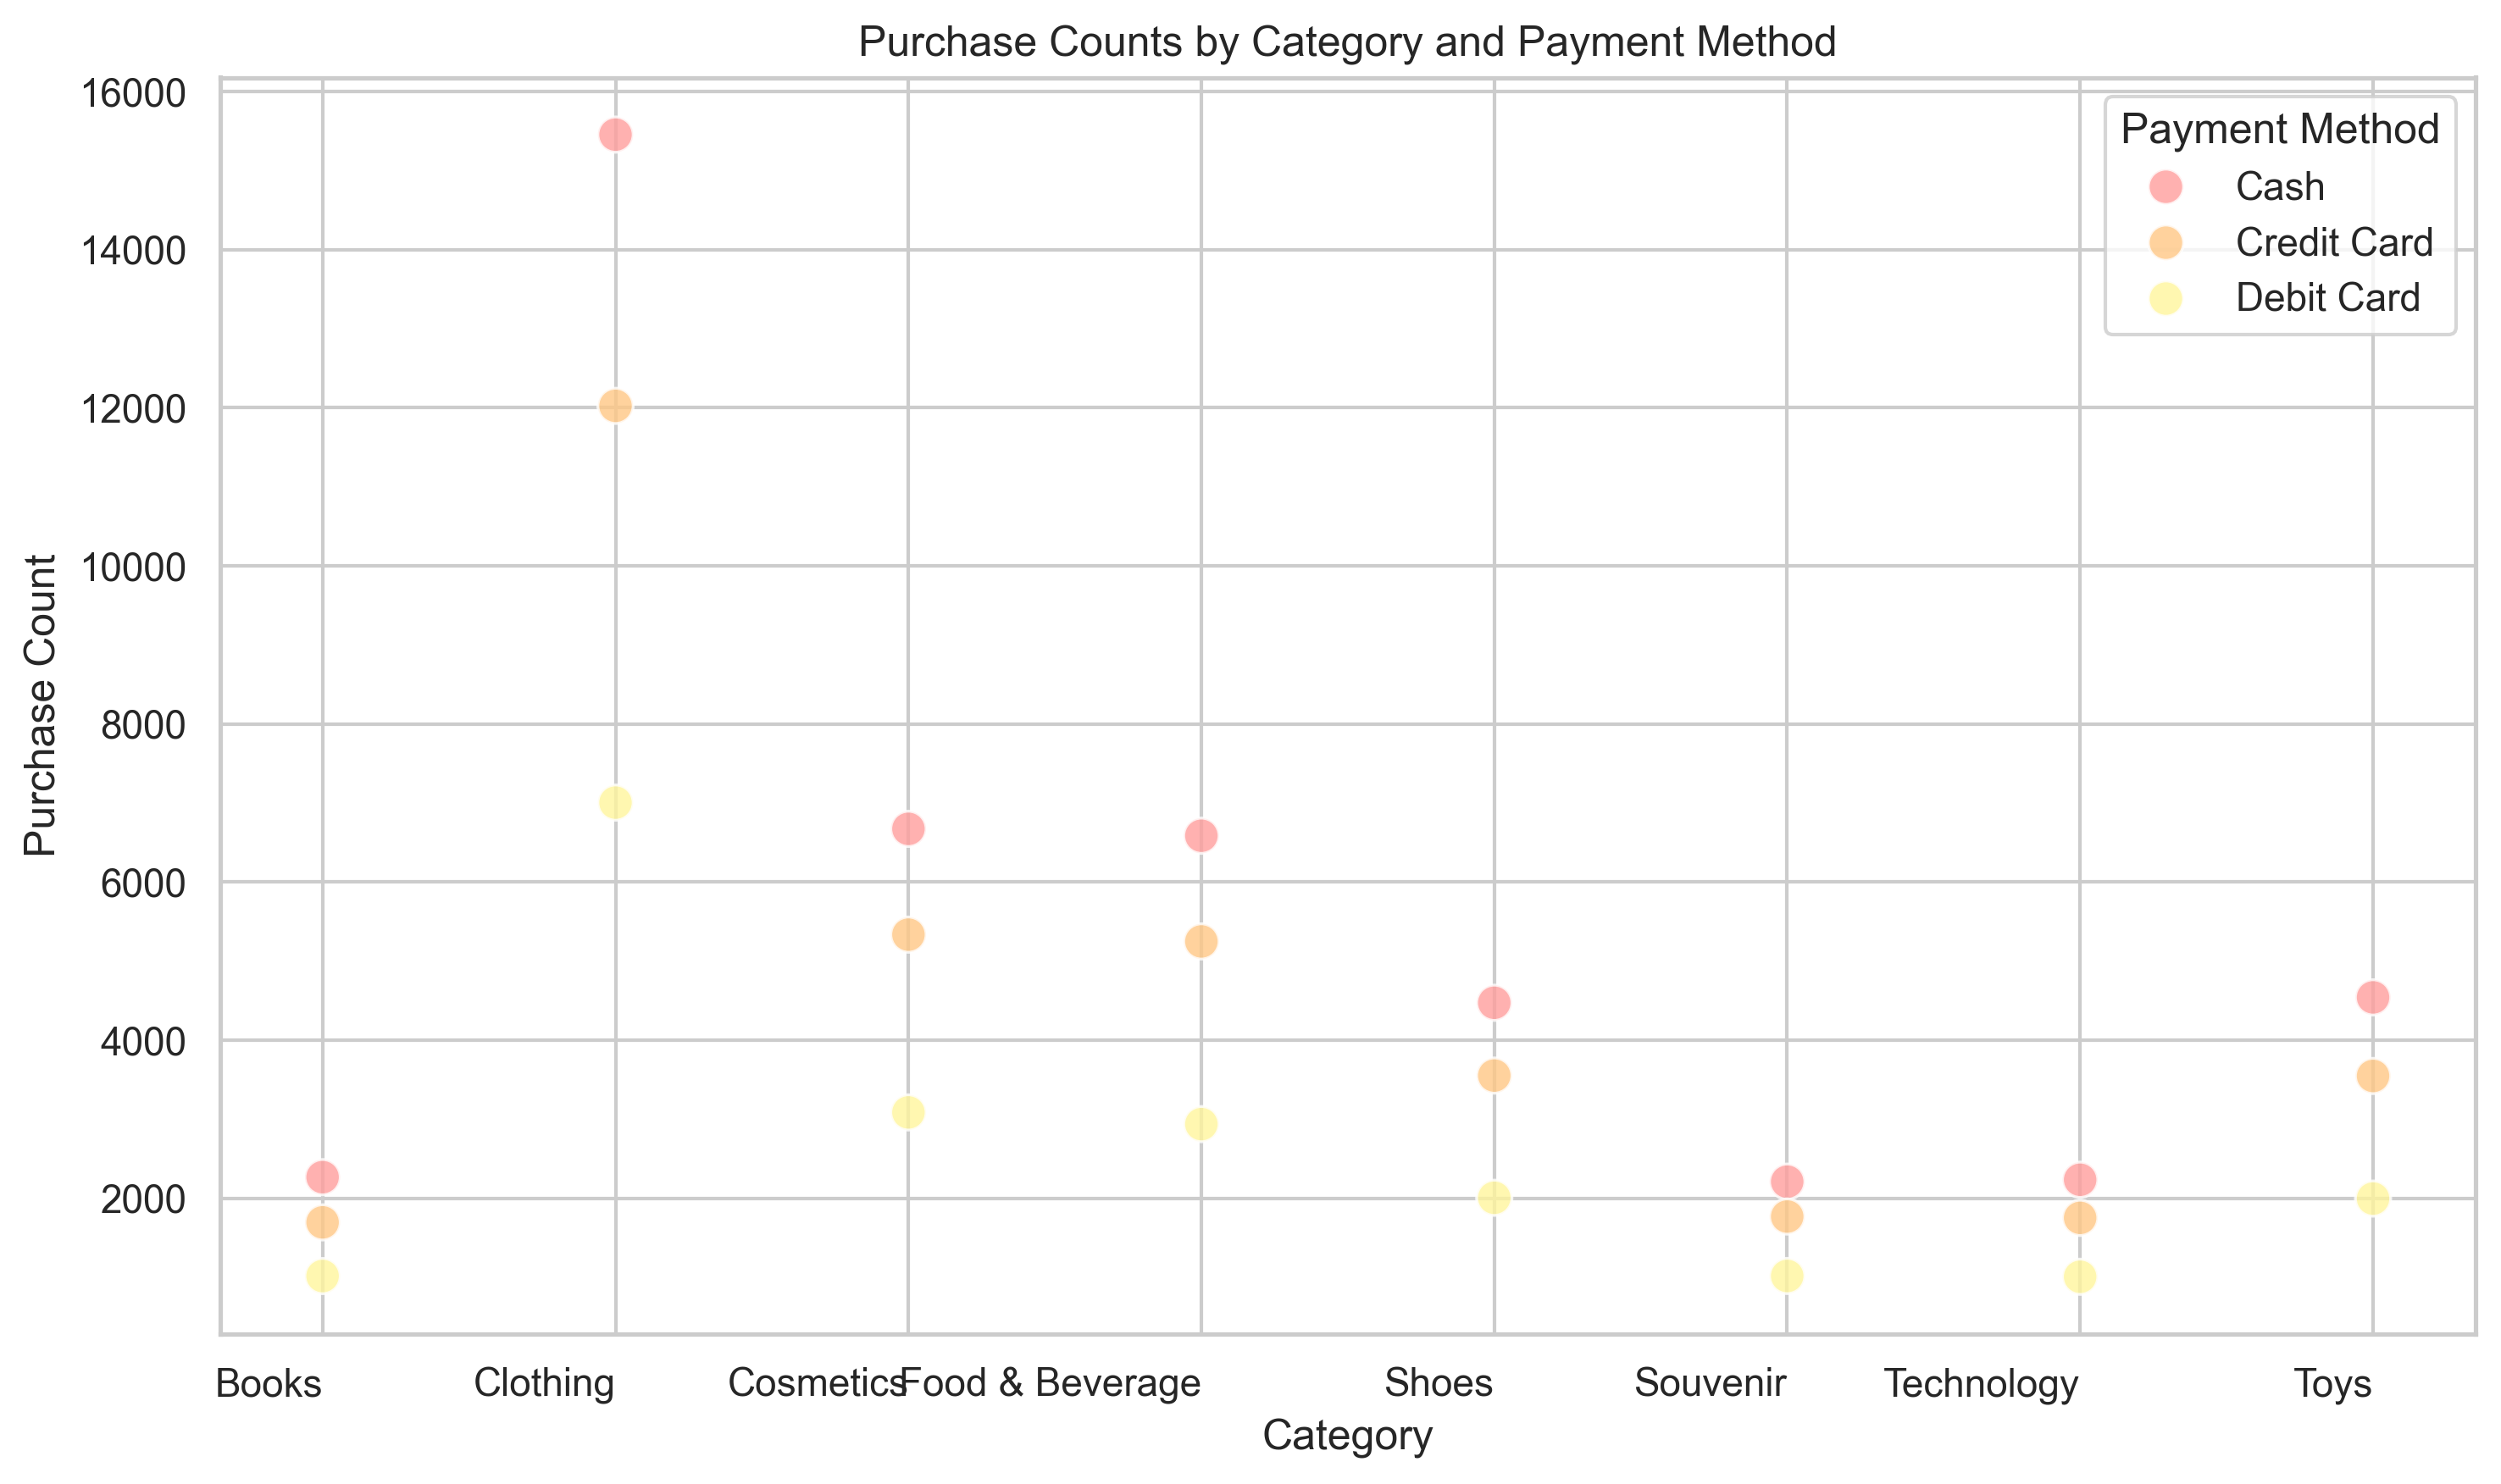

In [6]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ ANALYSIS: Does payment-method choice differ by product       ║
# ║          category?                                           ║
# ║ • Visual: Three bars per category, showing Cash/Credit/Debit ║
# ║ • Test: Chi-squared independence test                        ║
# ╚══════════════════════════════════════════════════════════════╝

# Contingency table
ct = pd.crosstab(df["category"], df["payment_method"])

cats    = ct.index.tolist()
methods = ["Cash", "Credit Card", "Debit Card"]
x       = np.arange(len(cats))
width   = 0.25

method_colors = {
    "Cash": color1,
    "Credit Card": color2,
    "Debit Card": color3
}

# Chi-squared test
chi2, p, dof, exp = stats.chi2_contingency(ct)
expected_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns)

print("\n=== Observed Counts ===")
print(ct)

print("\n=== Expected Counts under H0 ===")
print(expected_df.round(2))

print(f"\nχ² statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("\n✅ Conclusion: At the 95% confidence level, product category significantly influences payment-method choice.")
else:
    print("\n❌ Conclusion: No statistically significant association between product category and payment-method choice at the 95% confidence level.")

# Scatter Plot
scatter_data = ct.reset_index().melt(id_vars="category", var_name="payment_method", value_name="purchase_count")

plt.figure(figsize=(10,6), dpi=300)
sns.scatterplot(
    data=scatter_data,
    x="category",
    y="purchase_count",
    hue="payment_method",
    palette=method_colors,
    s=100,
    alpha=0.8
)
plt.ylabel("Purchase Count")
plt.xlabel("Category")
plt.title("Purchase Counts by Category and Payment Method")
plt.xticks(ha="right")
plt.legend(title="Payment Method")
plt.tight_layout()
plt.savefig('dataset_payment_behavior_figures/payment_category.png', dpi=300)
plt.show()


5. payment_method ↔ basket_total_price <br>  mnlogit
Which payment methods are used for high-value baskets?

Category mapping:
0: Cash
1: Credit Card
2: Debit Card
Optimization terminated successfully.
         Current function value: 1.050465
         Iterations 5
                           MNLogit Regression Results                          
Dep. Variable:     payment_method_code   No. Observations:                99457
Model:                         MNLogit   Df Residuals:                    99453
Method:                            MLE   Df Model:                            2
Date:                 Thu, 10 Jul 2025   Pseudo R-squ.:               2.075e-06
Time:                         16:02:41   Log-Likelihood:            -1.0448e+05
converged:                        True   LL-Null:                   -1.0448e+05
Covariance Type:             nonrobust   LLR p-value:                    0.8051
payment_method_code=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  

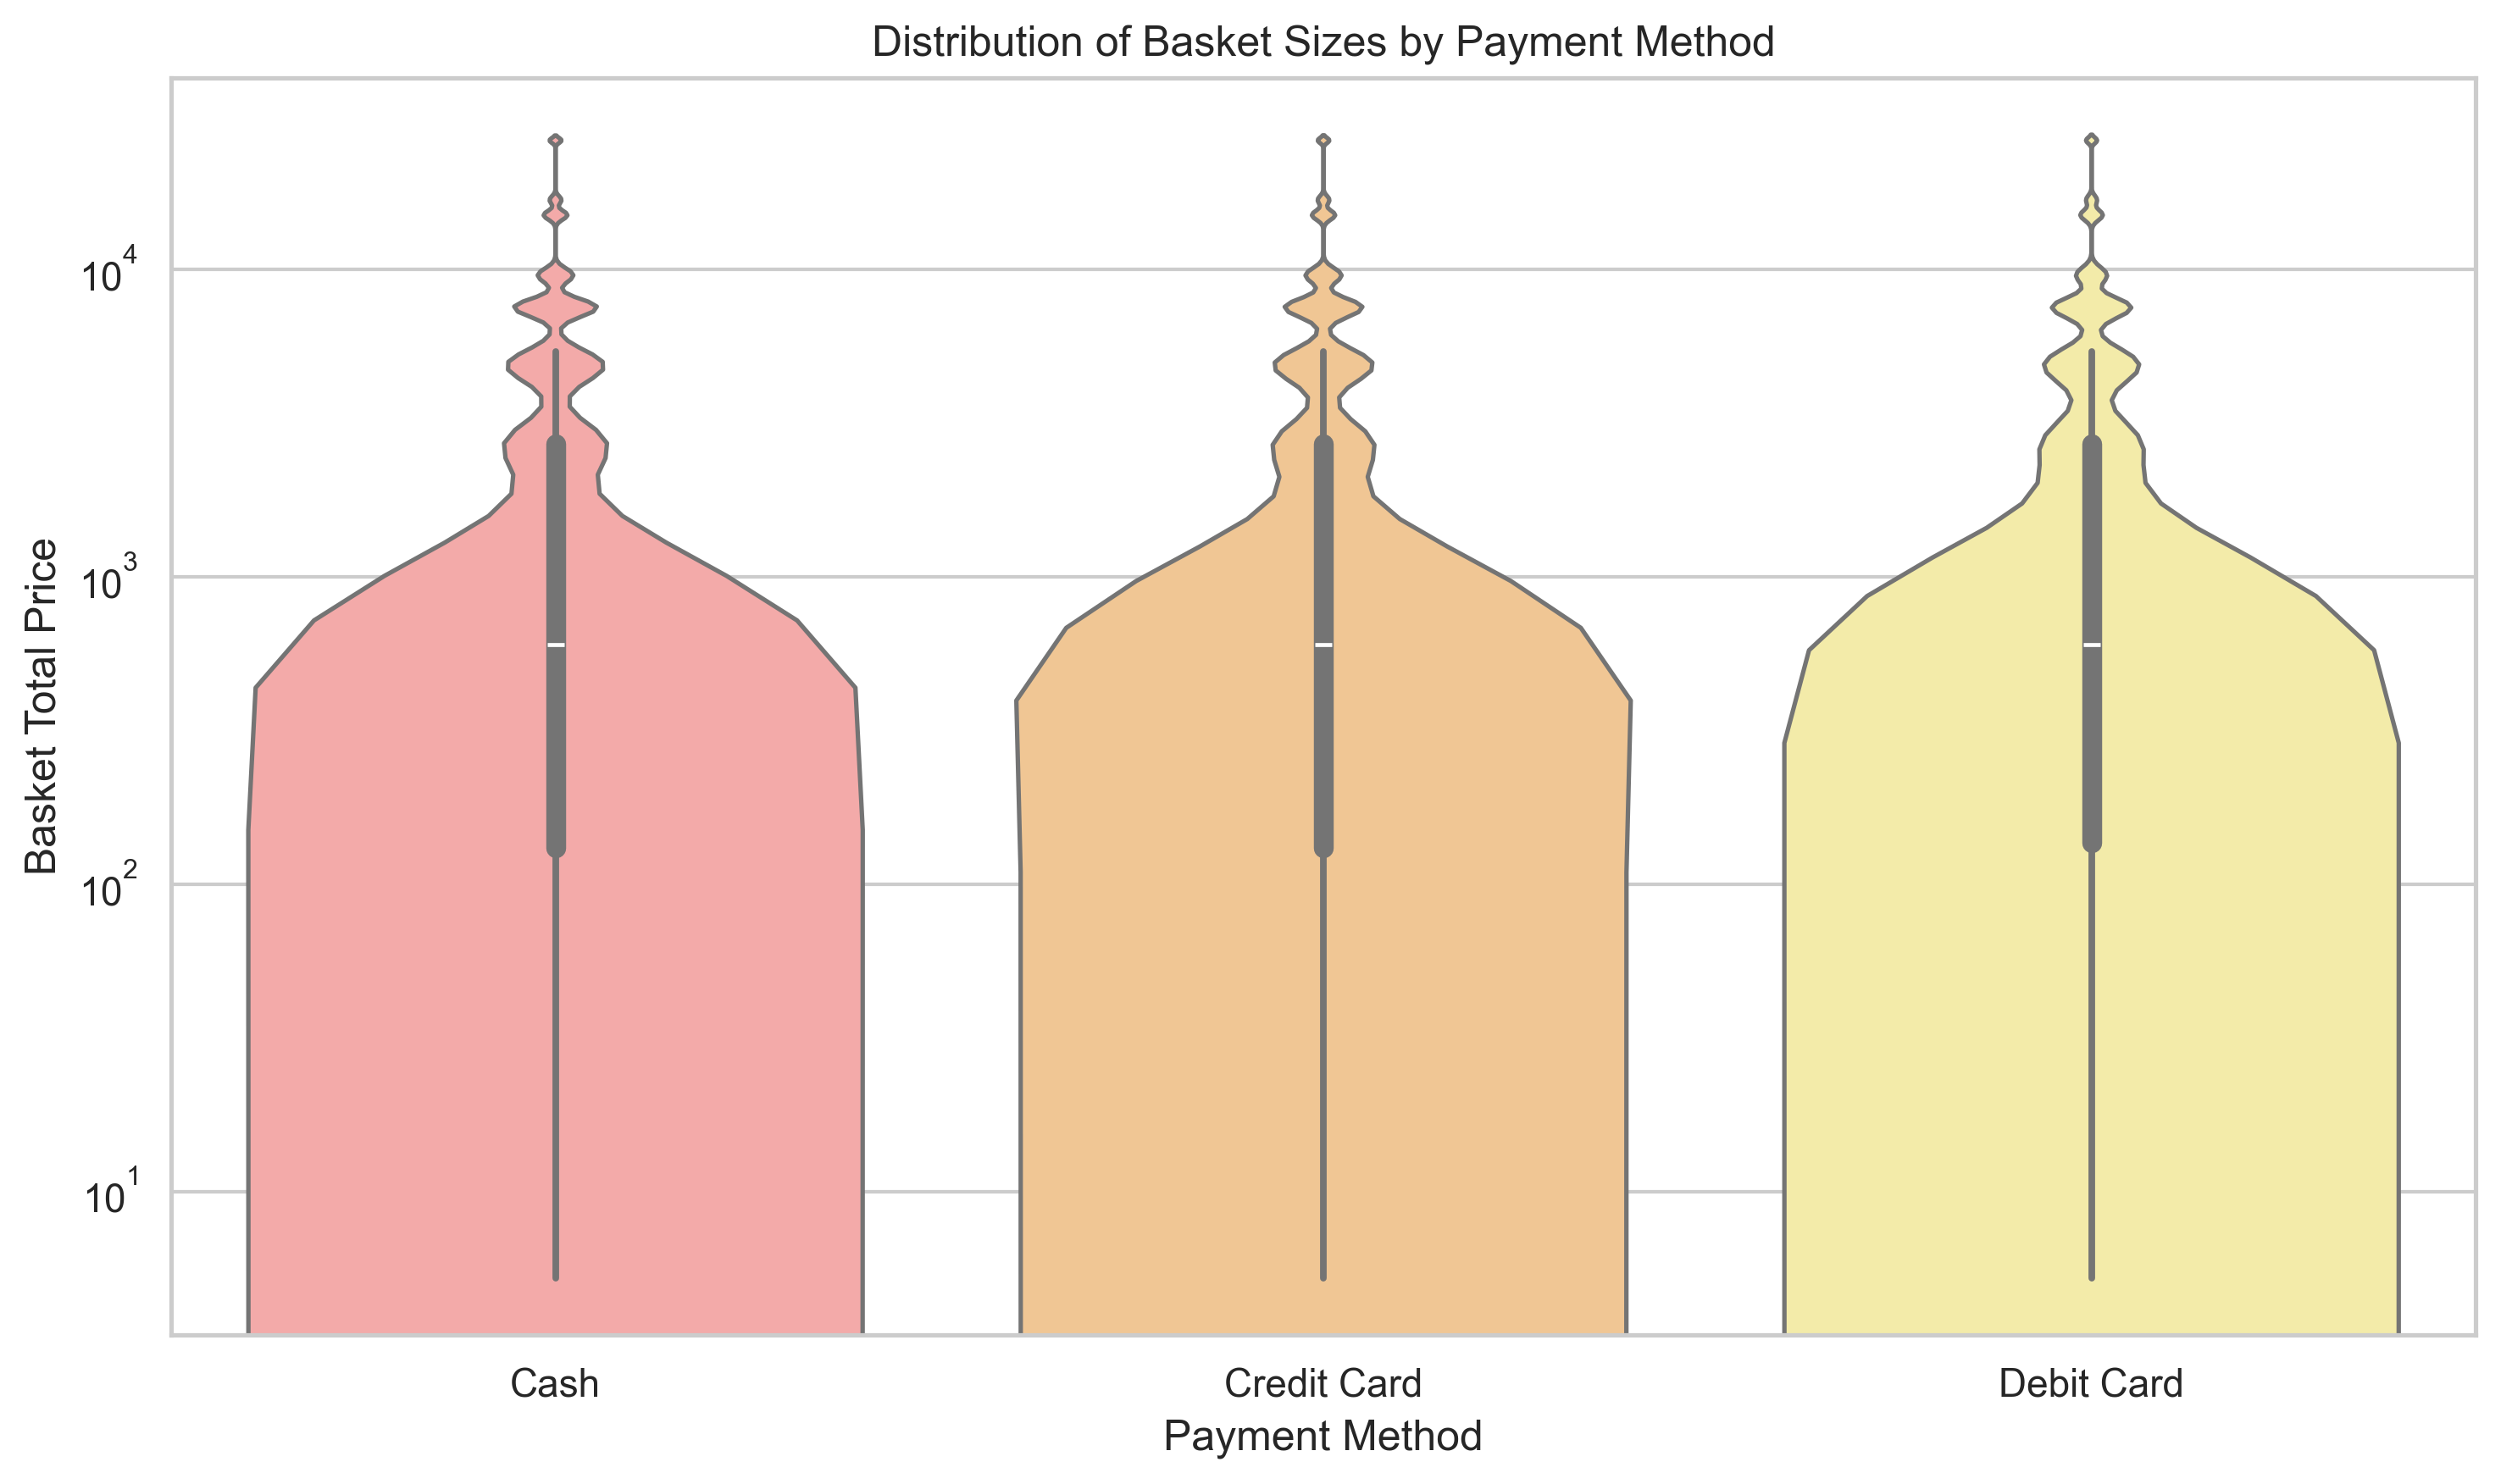

In [7]:

# Ensure payment_method is categorical
df["payment_method"] = df["payment_method"].astype("category")
df["payment_method_code"] = df["payment_method"].cat.codes

# Display mapping for reference
print("Category mapping:")
for code, label in enumerate(df["payment_method"].cat.categories):
    print(f"{code}: {label}")

# Create exog (predictor matrix) with constant
X = sm.add_constant(df["total_price"])

# Create endog (response)
y = df["payment_method_code"]

# Fit the model
model = sm.MNLogit(y, X).fit()

# Print regression summary
print(model.summary())

# Interpret each outcome category
params = model.params
pvalues = model.pvalues

# Payment method labels
labels = list(df["payment_method"].cat.categories)

# Remember: code 0 is baseline (Cash), 1 is Credit Card, 2 is Debit Card
mapping = {
    0: labels[0],
    1: labels[1],
    2: labels[2]
}

for col in params.columns:
    coef = params.loc["total_price", col]
    pval = pvalues.loc["total_price", col]
    label = mapping[col]

    print(f"\nPayment Method (vs Cash): {label}")
    if pval < 0.05:
        trend = "more likely" if coef > 0 else "less likely"
        print(f"✅ Significant: Higher basket value makes this payment method {trend}. (p={pval:.4f})")
    else:
        print(f"❌ Not significant: No strong association with basket value. (p={pval:.4f})")

plt.figure(figsize=(10,6), dpi=300)
sns.violinplot(
    data=df,
    x="payment_method",
    y="total_price",
    hue="payment_method",
    palette=[color1, color2, color3],
    inner="box"
)
plt.ylabel("Basket Total Price")
plt.xlabel("Payment Method")
plt.title("Distribution of Basket Sizes by Payment Method")
plt.yscale("log")  # log scale makes long tail visible
plt.tight_layout()
plt.savefig('dataset_payment_behavior_figures/payment_basket_price.png', dpi=300)
plt.show()


payment method - basket value segment low-middle-high mn logit

basket_value_group
Low (<500)           46669
High (>2000)         31796
Medium (500-2000)    19991
Name: count, dtype: int64

Observed Counts:
 payment_method       Cash  Credit Card  Debit Card
basket_value_group                                
Low (<500)          20802        16426        9441
Medium (500-2000)    8954         7023        4014
High (>2000)        14239        11134        6423

Chi² statistic: 0.5813
Degrees of freedom: 4
p-value: 0.9651


<Figure size 2400x1800 with 0 Axes>

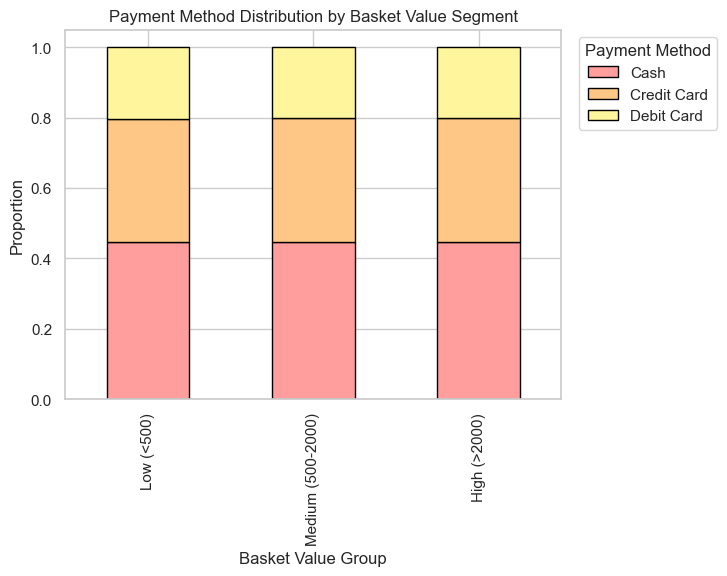

Optimization terminated successfully.
         Current function value: 1.050465
         Iterations 5
                           MNLogit Regression Results                          
Dep. Variable:     payment_method_code   No. Observations:                99457
Model:                         MNLogit   Df Residuals:                    99451
Method:                            MLE   Df Model:                            4
Date:                 Mon, 14 Jul 2025   Pseudo R-squ.:               2.565e-06
Time:                         16:08:03   Log-Likelihood:            -1.0448e+05
converged:                        True   LL-Null:                   -1.0448e+05
Covariance Type:             nonrobust   LLR p-value:                    0.9699
payment_method_code=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2367      0.010    -22.920      0.000      -0.257 

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Basket value segmentation
bins = [0, 500, 2000, df["total_price"].max()]
labels = ["Low (<500)", "Medium (500-2000)", "High (>2000)"]
df["basket_value_group"] = pd.cut(df["total_price"], bins=bins, labels=labels, right=False)

# Display counts per group
print(df["basket_value_group"].value_counts())

# Crosstab: basket value group x payment method
crosstab = pd.crosstab(df["basket_value_group"], df["payment_method"])
print("\nObserved Counts:\n", crosstab)

# Chi-squared test
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"\nChi² statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

# Visual: stacked bar proportions
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

plt.figure(figsize=(8,6), dpi=300)
crosstab_norm.plot(
    kind="bar",
    stacked=True,
    edgecolor="black",
    color=[color1,color2,color3]
)
plt.ylabel("Proportion")
plt.xlabel("Basket Value Group")
plt.title("Payment Method Distribution by Basket Value Segment")
plt.legend(title="Payment Method", loc="upper left", bbox_to_anchor=(1.02, 1))
plt.savefig('dataset_payment_behavior_figures/payment_basket_value_segment.png', dpi=300)
plt.show()

# OPTIONAL: Multinomial logistic regression
# Encode payment_method
df["payment_method"] = df["payment_method"].astype("category")
df["payment_method_code"] = df["payment_method"].cat.codes

# Create dummy variables for basket_value_group (drop first category to avoid dummy variable trap)
basket_dummies = pd.get_dummies(df["basket_value_group"], drop_first=True)

# Make sure dummies are float
basket_dummies = basket_dummies.astype(float)

# Add constant
X = sm.add_constant(basket_dummies).astype(float)

# Dependent variable
y = df["payment_method_code"]

# Fit multinomial logistic regression
model = sm.MNLogit(y, X).fit()
print(model.summary())

# Interpret coefficients
params = model.params
pvalues = model.pvalues

# Payment method labels
labels = list(df["payment_method"].cat.categories)

# Code mapping
mapping = {code: label for code, label in enumerate(labels)}

# Display coefficient interpretation
for col in params.columns:
    print(f"\nPayment Method (vs {labels[0]}): {mapping[col]}")
    for var in basket_dummies.columns:
        coef = params.loc[var, col]
        pval = pvalues.loc[var, col]
        if pval < 0.05:
            direction = "more likely" if coef > 0 else "less likely"
            print(f"✅ Significant: {var} baskets are {direction} to use this payment method (p={pval:.4f})")
        else:
            print(f"❌ Not significant association with {var} baskets (p={pval:.4f})")


paymnet method - basket segment ki kare

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Basket segmentation
bins = [0, 500, 2000, np.inf]
labels = ["Low", "Medium", "High"]
df["basket_segment"] = pd.cut(df["total_price"], bins=bins, labels=labels, right=False)

# Contingency table
ct = pd.crosstab(df["basket_segment"], df["payment_method"])
print("\nObserved Counts:")
print(ct)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(ct)
expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
print("\nExpected Counts Under H0:")
print(expected_df.round(2))
print(f"\nChi-Square = {chi2:.4f} (df = {dof})")
print(f"p-value = {p:.4f}")

if p < 0.05:
    print("✅ Significant association: Basket size and payment method are related.")
else:
    print("❌ No significant association: Basket size does not predict payment method.")

# Prepare data for scatter
ct_reset = ct.reset_index().melt(id_vars="basket_segment", var_name="payment_method", value_name="count")

# Encode basket segment for x-axis positions
segment_order = ["Low", "Medium", "High"]
segment_map = {seg: i for i, seg in enumerate(segment_order)}
ct_reset["segment_num"] = ct_reset["basket_segment"].map(segment_map)

# Scatter plot
plt.figure(figsize=(8,5), dpi=300)
palette = {"Cash":color1, "Credit Card":color2, "Debit Card":color3}

sns.scatterplot(
    data=ct_reset,
    x="segment_num",
    y="count",
    hue="payment_method",
    palette=palette,
    s=100,
    alpha=0.85
)

plt.xticks(ticks=[0,1,2], labels=segment_order)
plt.xlabel("Basket Size Segment")
plt.ylabel("Number of Transactions")
plt.title("Payment Method Counts by Basket Size Segment")
plt.legend(title="Payment Method")
sns.despine()
plt.tight_layout()
plt.savefig('dataset_payment_behavior_figures/payment_basket_value_segment_kikare.png', dpi=300)
plt.show()
